This notebook demonstrates training a cascade of convolutional neural networks for magnetic resonance image reconstruction. The model proposed by Souza et. al. [1] is used to produce an initial reconstruction also referred to as a single-visit reconstruction. To run this notebook, dockers latest version of tensorflow was used. The exact docker command used is:  

docker run -p 8888:8888 --gpus all -v $(pwd):/tf tensorflow/tensorflow:latest-gpu-jupyter 

[1] Souza, Roberto, R. Marc Lebel, and Richard Frayne. "A Hybrid, Dual Domain, Cascade of Convolutional Neural Networks for Magnetic Resonance Image Reconstruction." Proceedings of Machine Learning Research–XXXX 1 (2019): 11.

Subprocess used to install required libraries into docker container

In [1]:
import subprocess

def install(name):
    subprocess.call(['pip', 'install', name])

install('nibabel')
install('scikit-learn')

Import libraries and confirm that GPU is detected

In [1]:
import numpy as np
import os
import glob
import sys
import nibabel as nib
import logging
import matplotlib.pyplot as plt

# Importing our model
MY_UTILS_PATH = "../src/"
if not MY_UTILS_PATH in sys.path:
    sys.path.append(MY_UTILS_PATH)
import cs_models_sc as fsnet
import tensorflow as tf
# Importing callbacks and data augmentation utils

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import  Adam

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Load brain cancer data based on train/val split provided in data folder 

In [2]:
#location of brain-cancer data-set; change this path to destination of downloaded data
data_path = '../../../data/brain-cancer/'

train_files = np.loadtxt('../data/train_val_test_split/train_initial.txt', dtype=str)
val_files = np.loadtxt('../data/train_val_test_split/val_initial.txt', dtype=str)



In [3]:
print('The number of training volumes is',  len(train_files))
print('The number of validation volumes is',  len(val_files))

The number of training volumes is 5
The number of validation volumes is 4


Load the training data as k-space and reconstruction with imaginary and real components separated into their own channel. 

In [4]:
rec_train = []
kspace_train = []
for file in train_files:
    #load reconstructed volumes
    rec = nib.load(data_path + file).get_fdata()[:,:,20:-20]
    #normalize based on max value of volume
    aux_rec = np.swapaxes(rec,0,2) / np.abs(rec).max()

    #convert reconstruction to k-space
    f = np.fft.fft2(aux_rec)
    aux_kspace = np.zeros((*aux_rec.shape,2))
    #resolve real and imaginary components of k-space into seperate channels
    aux_kspace[:,:,:,0] = f.real
    aux_kspace[:,:,:,1] = f.imag
    kspace_train.append(aux_kspace)
    
    #get complex reconstruction by taking inverse fourier 
    rec = np.fft.ifft2(f)
    #resolve real and imaginary components of image into separate channels
    aux2_rec = np.zeros((*aux_rec.shape,2))
    aux2_rec[:,:,:,0] = rec.real
    aux2_rec[:,:,:,1] = rec.imag
    rec_train.append(aux2_rec)

rec_train = np.concatenate(rec_train)
kspace_train = np.concatenate(kspace_train)

In [5]:
print('the number of training slices is,', rec_train.shape[0])

the number of training slices is, 608


Do the same for the validation data



In [6]:
rec_val = []
kspace_val = []
for file in val_files:
    #load reconstructed volumes
    rec = nib.load(data_path + file).get_fdata()[:,:,20:-20]
    #normalize based on max value of volume
    aux_rec = np.swapaxes(rec,0,2) / np.abs(rec).max()

    #convert reconstruction to k-space
    f = np.fft.fft2(aux_rec)
    aux_kspace = np.zeros((*aux_rec.shape,2))
    #resolve real and imaginary components of k-space into seperate channels
    aux_kspace[:,:,:,0] = f.real
    aux_kspace[:,:,:,1] = f.imag
    kspace_val.append(aux_kspace)
    
    #get complex reconstruction by taking inverse fourier 
    rec = np.fft.ifft2(f)
    #resolve real and imaginary components of image into separate channels
    aux2_rec = np.zeros((*aux_rec.shape,2))
    aux2_rec[:,:,:,0] = rec.real
    aux2_rec[:,:,:,1] = rec.imag
    rec_val.append(aux2_rec)

rec_val = np.concatenate(rec_val)
kspace_val = np.concatenate(kspace_val)

In [7]:
print('the number of validation slices is,', rec_val.shape[0])

the number of validation slices is, 511


Load the sampling masks for an acceleration factor of R=10x

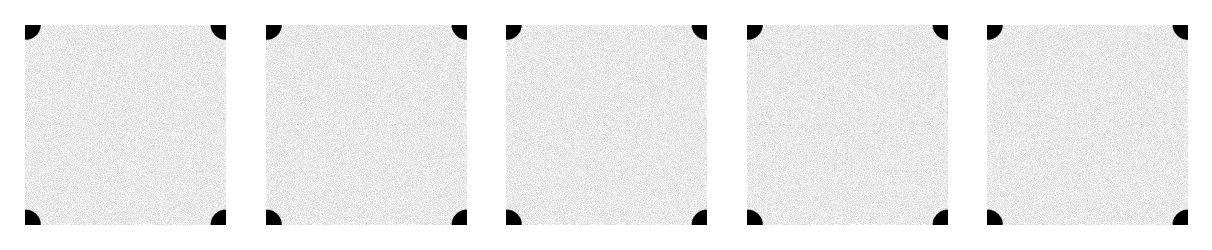

Undersampling: 0.8993552780151367


In [8]:
# Loading sampling patterns. Notice that here we are using uncentred k-space
var_sampling_mask = np.fft.fftshift(~np.load("../data/sampling_masks/R10_512x512_poisson_center_true_radius_40_r_2.66.npy"),axes=(1,2))
var_sampling_mask = np.concatenate((var_sampling_mask[:,:,:,np.newaxis],var_sampling_mask[:,:,:,np.newaxis]),\
                               
                                   axis = -1)


# White pixels are retrospectively discarded
plt.figure(dpi = 250)
for ii in range(5):
    plt.subplot(1,5,ii+1)
    plt.imshow(var_sampling_mask[ii*10,:,:,0],cmap = "gray")
    plt.axis("off")
plt.show()

print("Undersampling:", 1.0*var_sampling_mask.sum()/var_sampling_mask.size)

Define model architecture, parameters for training, and path to save model weights

In [9]:
epochs = 100
batch_size= 6
os.makedirs('../models/', exist_ok=True)
model_name = "../models/flat_unrolled_cascade_iki.hdf5"

# Early stopping callback to shut down training after
# 5 epochs with no improvement
earlyStopping = EarlyStopping(monitor='val_loss',
                                       patience=5, 
                                       verbose=0, mode='min')

# Checkpoint callback to save model  along the epochs
checkpoint = ModelCheckpoint(model_name, mode = 'min', \
                         monitor='val_loss',verbose=0,\
                         save_best_only=True, save_weights_only = True)

Apply data augmentation to increase the number of training samples and variance of dataset 

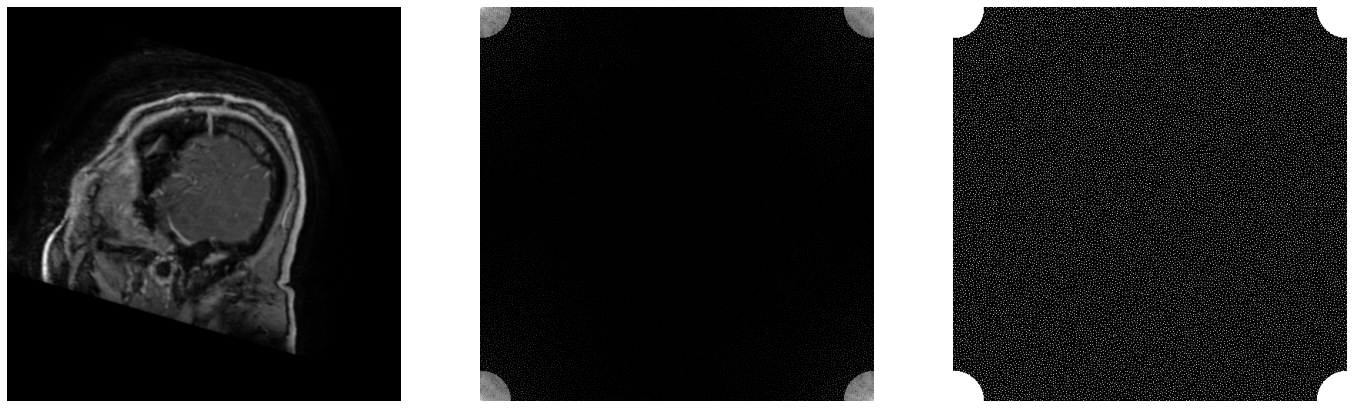

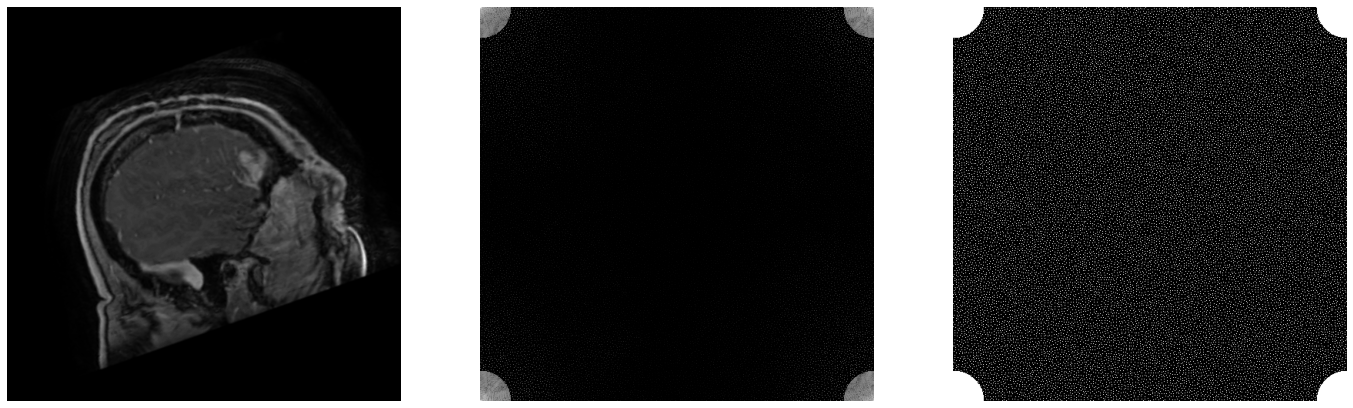

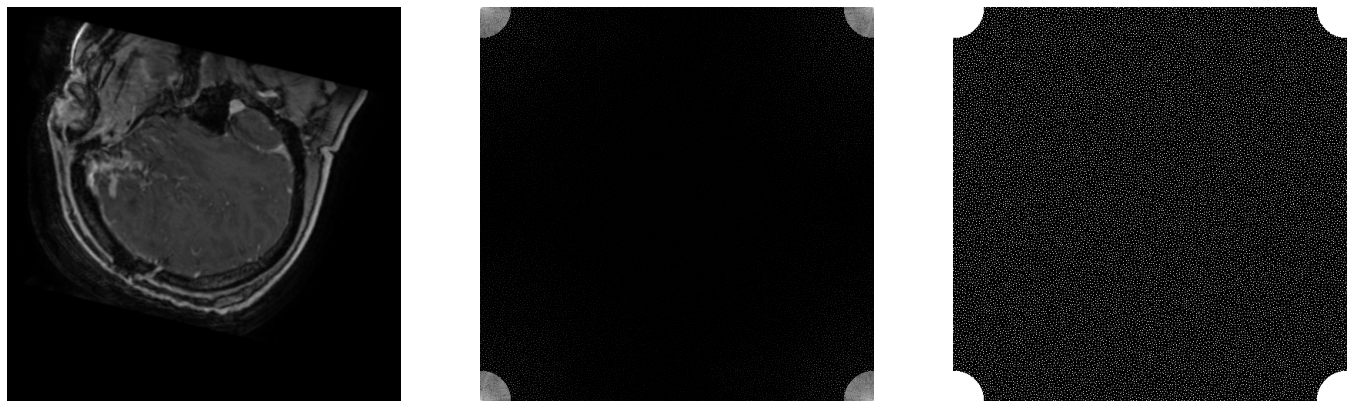

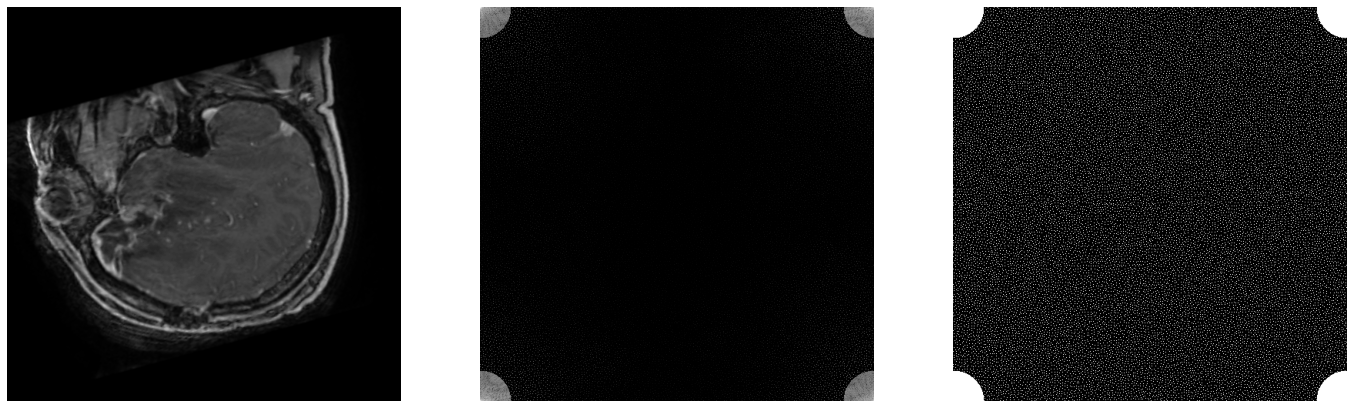

In [10]:
# On the fly data augmentation
def combine_generator(gen1,gen2,under_masks):
    while True:
        rec_real = gen1.next()
        rec_imag = gen2.next()
        f = np.fft.fft2(rec_real[:,:,:,0]+1j*rec_imag[:,:,:,0])
        #kspace = np.fft.ifftshift(f)
        kspace2 = np.zeros((f.shape[0],f.shape[1],f.shape[2],2))
        kspace2[:,:,:,0] = f.real
        kspace2[:,:,:,1] = f.imag
        indexes = np.random.choice(np.arange(under_masks.shape[0], dtype=int), rec_real.shape[0], replace=False)
        kspace2[under_masks[indexes]] = 0
        
        rec_complex = np.zeros((rec_real.shape[0],rec_real.shape[1],rec_real.shape[2],2),dtype = np.float32)
        rec_complex[:,:,:,0] = rec_real[:,:,:,0]
        rec_complex[:,:,:,1] = rec_imag[:,:,:,0]
        
        yield([kspace2,under_masks[indexes].astype(np.float32)],[rec_complex])
        
seed = 905
image_datagen1 = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest')

image_datagen2 = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest')


image_generator1 = image_datagen1.flow(rec_train[:,:,:,0,np.newaxis],batch_size = batch_size,seed = seed, shuffle=False)
image_generator2 = image_datagen2.flow(rec_train[:,:,:,1,np.newaxis],batch_size = batch_size,seed = seed, shuffle=False)        


combined = combine_generator(image_generator1,image_generator2, var_sampling_mask)

# Dispaly sample data augmentation
counter = 0
for ii in combined:
    
    fback = np.fft.ifft2(ii[0][0][4,:,:,0]+1j*ii[0][0][4,:,:,1])
    img = np.abs(ii[1][0][4,:,:,0]+1j*ii[1][0][4,:,:,0])
    plt.figure(figsize=(24,10))
    plt.subplot(131)
    plt.imshow(img,cmap = 'gray')
    plt.axis("off")
    plt.subplot(132)
    plt.imshow(np.log(1+np.abs(ii[0][0][4,:,:,0] + 1j*ii[0][0][4,:,:,1])),cmap = 'gray')
    plt.axis("off")
    plt.subplot(133)
    plt.imshow(ii[0][0][4,:,:,0].astype(bool),cmap = 'gray')
    plt.axis("off")

    counter+=1
    if counter > 3:
        break

In [11]:
# Undersampling the validation set
indexes = np.random.choice(np.arange(var_sampling_mask.shape[0],dtype =int),kspace_val.shape[0],replace = True)
val_var_sampling_mask = (var_sampling_mask[indexes])
kspace_val[val_var_sampling_mask] = 0

In [12]:
# Training our model
model = fsnet.deep_cascade_flat_unrolled("iki", 512, 512)
opt = Adam(lr = 1e-3,decay = 1e-4)
model.compile(loss = 'mse',optimizer=opt)
print(model.summary())

hist = model.fit_generator(combined,
             epochs=epochs,
             steps_per_epoch=rec_train.shape[0]//batch_size,
             verbose=1,
             validation_data= ([kspace_val,val_var_sampling_mask],[rec_val]),
             callbacks=[checkpoint,earlyStopping])

/usr/local/lib/python3.6/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 2) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 512, 512, 2)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 48) 912         lambda[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 512, 512, 48) 0           conv2d[0][0]                     
______________________________________________________________________________________________

Epoch 1/100
101/101 [==============================] - 36s 324ms/step - loss: 1.5821e-04 - val_loss: 1.3778e-04
Epoch 2/100
101/101 [==============================] - 29s 288ms/step - loss: 1.1906e-04 - val_loss: 1.2257e-04
Epoch 3/100
101/101 [==============================] - 29s 289ms/step - loss: 1.1037e-04 - val_loss: 1.2046e-04
Epoch 4/100
101/101 [==============================] - 31s 303ms/step - loss: 1.0621e-04 - val_loss: 1.0698e-04
Epoch 5/100
101/101 [==============================] - 31s 308ms/step - loss: 1.0215e-04 - val_loss: 1.0205e-04
Epoch 6/100
101/101 [==============================] - 31s 310ms/step - loss: 9.9559e-05 - val_loss: 9.7418e-05
Epoch 7/100
101/101 [==============================] - 31s 310ms/step - loss: 9.7284e-05 - val_loss: 9.5053e-05
Epoch 8/100
101/101 [==============================] - 31s 311ms/step - loss: 9.5539e-05 - val_loss: 9.3481e-05
Epoch 9/100
101/101 [==============================] - 32s 313ms/step - loss: 9.4102e-05 - val_loss: 9.2